### ISSUES and TODOs

- see `README.md`

1) use one-sided spectrum

2) sometimes FD after augmentation is just a flat line. Why?

3) is it VALID to zero out frequency coefficients for augmentation?

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

import os, argparse, json, copy, wandb

import umap
from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.fft as fft
from einops import rearrange, repeat

import pandas as pd
import numpy as np
from termcolor import cprint
from pprint import pprint
from tqdm import tqdm
from datetime import datetime

from train import finetune

from trainer import Trainer, model_finetune, model_test, model_pretrain
from train import evaluate

from augmentations import *
from dataloader import MIdatasetMC
from config_files.BIG_EEG_MI_1chRearrange_bigger import Config as Configs
from utils import _logger, set_requires_grad
from model import *
from utils import _calc_metrics, copy_Files
from loss import * # base_Model, base_Model_F, target_classifier
from sklearn.metrics import cohen_kappa_score as kappa



# For Arial
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams["text.usetex"] = False

# for latex:
# matplotlib.rcParams['font.family'] = "DejaVu Sans"
# matplotlib.rcParams['font.serif'] = "Computer Modern"
# matplotlib.rcParams["text.usetex"] = True

matplotlib.rcParams["lines.linewidth"] = 3
matplotlib.rcParams["xtick.direction"] = "out"
matplotlib.rcParams["ytick.direction"] = "out"
matplotlib.rcParams["axes.labelsize"] = 22
matplotlib.rcParams["xtick.labelsize"] = 22
matplotlib.rcParams["ytick.labelsize"] = 22
matplotlib.rcParams["font.size"] = 22
matplotlib.rcParams["legend.fontsize"] = 22
matplotlib.rcParams["axes.titlesize"] = 22
matplotlib.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams["figure.autolayout"] = True

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}'

print(f'CUDA available: {torch.cuda.is_available()}')
cprint(torch.__version__, color='green')
device_count = torch.cuda.device_count()
for i in range(device_count):
    torch.cuda.set_device(i)
    cur_device_id = torch.cuda.current_device()
    cur_device_name = torch.cuda.get_device_name(cur_device_id)
    print(f'Current device:\nID {cur_device_id} | Name: {cur_device_name}')
    print(f'supported arch list: {torch.cuda.get_arch_list()}\n')
    

2022-09-27 14:25:41.640862: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


CUDA available: True
1.12.1+cu113
Current device:
ID 0 | Name: RTX A6000
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']

Current device:
ID 1 | Name: Quadro P2200
supported arch list: ['sm_37', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'sm_80', 'sm_86']



In [5]:
training_mode = 'pre_train'   # 'fine_tune_test'
device = 'cuda:0'
configs = Configs()
# configs.report()


In [6]:
!pwd

/home/roman/CODE/TFC/code


In [7]:
# load the data and instantiate the Dataset class

# path = '/home/roman/CODE/tachikoma-analysis/DATA2'
path = '../DATA2'


# load the torch tensor
dataset = torch.load(os.path.join(path, "BIG_MI_12_datasets_53213samp.pt"))
dataset['info']

"Srate = 100 Hz, passband: 0-45 Hz, channels ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']. See meta for more details. See /home/roman/CODE/tachikoma-analysis/DATA"

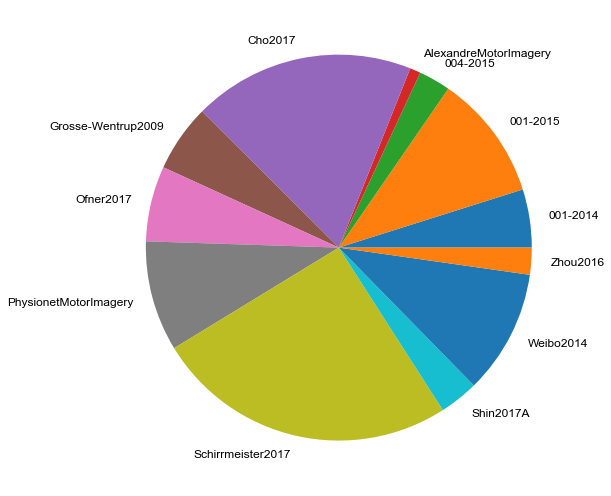

In [49]:
# fig, ax = plt.subplots(1, 1, figsize=(10, 7))
# tmp = dataset['meta'].groupby('ds').ds.count()#.plot.pie(ax=ax, fontsize=13, legend=None)
# tmp = pd.DataFrame(tmp)
# labels = [i[4:-3] for i in tmp.index]
# _ = ax.pie(tmp.values.flatten(), labels=labels, textprops={'fontsize': 12})
# # sizes, explode=explode, labels=labels
# # tmp



In [6]:
from dataset_utils import *

In [7]:
print(dataset['meta'].ds.unique())

targetDsName = 'BNCIPhysionetMotorImagery.pt'
test_subject = 2
shuffle = False

pretrain_dataset, target_dataset = SplitIntoPretrainAndFinetune(dataset, targetDsName)
finetune_dataset, test_dataset = get_train_test_datasets(target_dataset, shuffle=shuffle, test_subject=test_subject)


['BNCIOfner2017.pt' 'BNCISchirrmeister2017.pt' 'BNCI004-2015.pt'
 'BNCICho2017.pt' 'BNCI001-2014.pt' 'BNCIPhysionetMotorImagery.pt'
 'BNCI001-2015.pt' 'BNCIGrosse-Wentrup2009.pt' 'BNCIWeibo2014.pt'
 'BNCIZhou2016.pt' 'BNCIAlexandreMotorImagery.pt' 'BNCIShin2017A.pt']
BNCIPhysionetMotorImagery.pt
pretrain_dataset: torch.Size([48295])
['right_hand' 'left_hand']
target_dataset: torch.Size([4918])
Total samples in pretrain and finetune: 53213
test_subject: 2
Shuffle: False
torch.Size([4873, 7, 120]), torch.Size([45, 7, 120])


In [8]:
finetune_dataset['meta']

,subject,session,run,label,ds,class_id
30736,1,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30737,1,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30738,1,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30739,1,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30740,1,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
...,...,...,...,...,...,...
35649,109,session_0,run_2,left_hand,BNCIPhysionetMotorImagery.pt,1
35650,109,session_0,run_2,right_hand,BNCIPhysionetMotorImagery.pt,0
35651,109,session_0,run_2,left_hand,BNCIPhysionetMotorImagery.pt,1
35652,109,session_0,run_2,right_hand,BNCIPhysionetMotorImagery.pt,0


In [9]:
test_dataset['meta']

,subject,session,run,label,ds,class_id
30781,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30782,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30783,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30784,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30785,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30786,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30787,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30788,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30789,2,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30790,2,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1


In [10]:
set(finetune_dataset['meta'].index.tolist()).intersection(set(test_dataset['meta'].index.tolist()))

set()

In [11]:
pretrain_dataset['samples'].shape, finetune_dataset['samples'].shape, test_dataset['samples'].shape

(torch.Size([48295, 7, 120]),
 torch.Size([4873, 7, 120]),
 torch.Size([45, 7, 120]))

In [12]:
# seed everything
SEED = 0
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [37]:
# instantiate the Dataset class
ds = MIdatasetMC(pretrain_dataset, configs)

torch.Size([48295, 7, 120])


Text(0.5, 0.98, 'Sample ID: 12002')

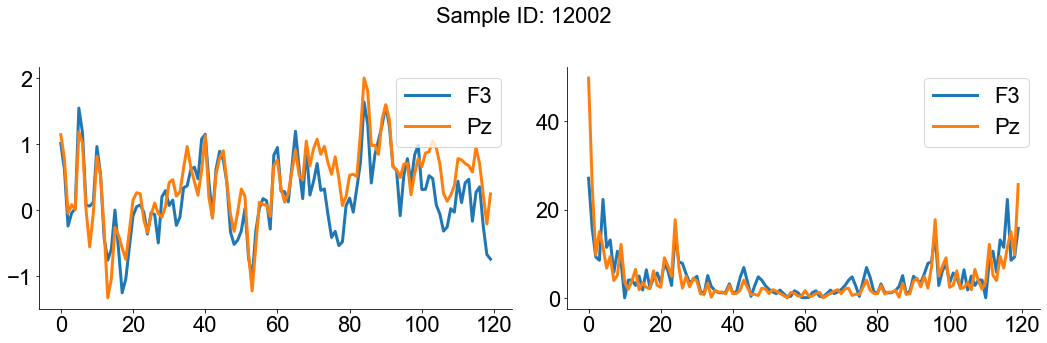

In [38]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15,5))

sampid = np.random.choice(len(ds))
sampid = 12002

choi = ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']


x,_,_,_,_,_,_,_ = ds[sampid]
x_f = fft.fft(x).abs()

ax0.plot(x[choi.index('F3'),:].squeeze().numpy(), label=f'{choi[0]}')
ax0.plot(x[choi.index('F4'),:].squeeze().numpy(), label=f'{choi[-1]}')
ax0.legend()

ax1.plot(x_f[choi.index('F3'),:].squeeze().numpy(), label=f'{choi[0]}')
ax1.plot(x_f[choi.index('F4'),:].squeeze().numpy(), label=f'{choi[-1]}')
ax1.legend()

plt.suptitle(f'Sample ID: {sampid}', fontsize=22)

In [39]:
# metadata per each data point (for debugging)

finetune_dataset['meta']

,subject,session,run,label,ds,class_id
30736,1,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30737,1,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30738,1,session_0,run_0,left_hand,BNCIPhysionetMotorImagery.pt,1
30739,1,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
30740,1,session_0,run_0,right_hand,BNCIPhysionetMotorImagery.pt,0
...,...,...,...,...,...,...
35649,109,session_0,run_2,left_hand,BNCIPhysionetMotorImagery.pt,1
35650,109,session_0,run_2,right_hand,BNCIPhysionetMotorImagery.pt,0
35651,109,session_0,run_2,left_hand,BNCIPhysionetMotorImagery.pt,1
35652,109,session_0,run_2,right_hand,BNCIPhysionetMotorImagery.pt,0


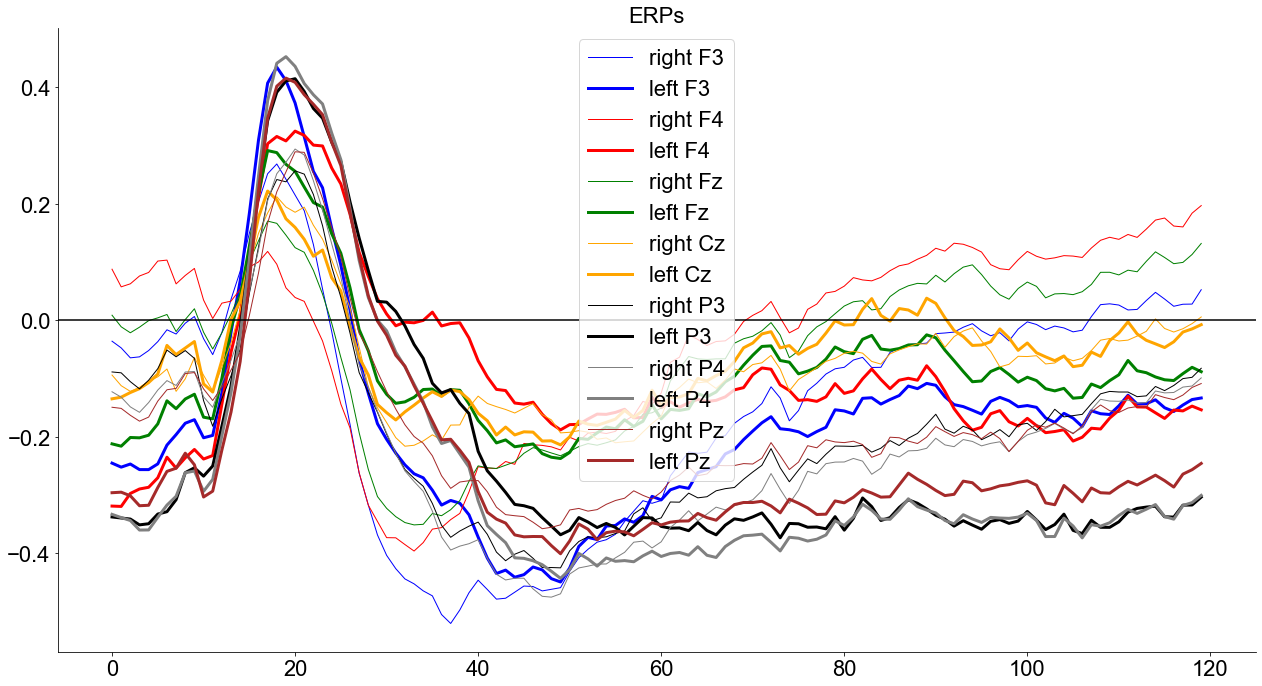

In [40]:
c = ['blue', 'red', 'green', 'orange', 'black', 'grey', 'brown']

plt.figure(figsize=(18, 10))

rights = np.where(finetune_dataset['meta'].class_id == 0)[0]
lefts =  np.where(finetune_dataset['meta'].class_id == 1)[0]

for i in range(7):
    plt.plot(finetune_dataset['samples'][rights, i,: ].mean(axis=0).squeeze(), color=c[i], lw=1, label=f'right {choi[i]}')
    plt.plot(finetune_dataset['samples'][lefts,  i,: ].mean(axis=0).squeeze(), color=c[i], lw=3, label=f'left {choi[i]}')
    
plt.legend()
plt.axhline(0, color='k', lw=1.5)

_ = plt.title('ERPs')

In [41]:
# get one data point (not batch)

x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta = ds[1000]
meta, y

({'subject': 5,
  'session': 'imagination',
  'run': 'run_1',
  'label': 'right_supination',
  'ds': 'BNCIOfner2017.pt',
  'class_id': 3},
 tensor(3))

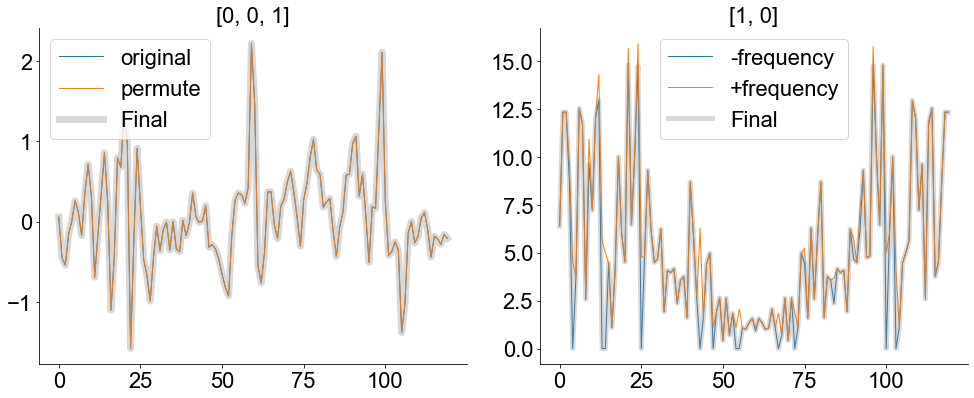

In [42]:
# validate augmentations (debugging)

ch = 4

x_t, _, _, x_f, _, _, _,_ = ds[2]
aug_T, aug_1_t, aug_2_t, aug_3_t, msk_t = DataTransform_TD(x_t, configs)
aug_F, aug_1_f, aug_2_f, msk_f = DataTransform_FD(x_f, configs)

n = np.random.choice(x_t.shape[0])


fig, (ax, ax1) = plt.subplots(1,2,figsize=(14,6))

if len(x_t.shape) == 2:
    ax.plot(x_t[ch,:].detach().numpy(), lw=1, label='original')
    if np.argmax(msk_t.tolist()) == 0:
        ax.plot(aug_1_t[ch,:].detach().numpy(), lw=1, label='jitter')
    elif np.argmax(msk_t.tolist()) == 1:
        ax.plot(aug_2_t[ch,:].detach().numpy(), lw=1, label='scale')
    elif np.argmax(msk_t.tolist()) == 2:
        ax.plot(aug_3_t[ch,:].detach().numpy(), lw=1, label='permute')
    else:
        raise
    ax.plot(aug_T[ch,:].detach().numpy(), lw=7, alpha=0.3, color='grey', label='Final')
    ax.set_title(msk_t.tolist())
    ax.legend()


    ax1.plot(aug_1_f[ch,:].detach().numpy(), lw=1, label='-frequency')
    ax1.plot(aug_2_f[ch,:].detach().numpy(), lw=1, label='+frequency')
    ax1.plot(aug_F[ch,:].detach().numpy(), lw=5, alpha=0.3, color='grey', label='Final')
    ax1.set_title(msk_f.tolist())
    ax1.legend()
    # ax1.set_ylim(0, 20)
    # ax1.set_xlim(150, 250)
    
if len(x_t.shape) == 3:
    ax.plot(x_t[n, ch,:].detach().numpy(), lw=1, label='original')
    ax.plot(aug_1_t[n, ch,:].detach().numpy(), lw=1, label='jitter')
    ax.plot(aug_2_t[n, ch,:].detach().numpy(), lw=1, label='scale')
    ax.plot(aug_3_t[n, ch,:].detach().numpy(), lw=1, label='permute')
    ax.plot(aug_T[n, ch,:].detach().numpy(), lw=7, alpha=0.3, color='grey', label='Final')
    ax.set_title(msk_t[n,:].tolist())
    ax.legend()


    ax1.plot(aug_1_f[n, ch,:].detach().numpy(), lw=1, label='-frequency')
    ax1.plot(aug_2_f[n, ch,:].detach().numpy(), lw=1, label='+frequency')
    ax1.plot(aug_F[n, ch,:].detach().numpy(), lw=5, alpha=0.3, color='grey', label='Final')
    ax1.set_title(msk_f[n,:].tolist())
    ax1.legend()
    # ax1.set_ylim(0, 20)
#     ax1.set_xlim(150, 250)


In [43]:
# create a dataloader with the optimal number of workers

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

train_dl = torch.utils.data.DataLoader(
    dataset=ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=14) # optimal: 14 workers with batch_size=60

In [44]:
# %%time
for x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta in tqdm(train_dl, bar_format=bar_format):
    pass

x_t.shape, y.shape, x_t_aug.shape

100%|██████████| 503/503 [00:05<00:00, 87.77it/s]                                                                                                             


(torch.Size([96, 7, 120]), torch.Size([96]), torch.Size([96, 7, 120]))

In [45]:
# for debugging, inspect where each data point comes from

pd.DataFrame(meta).head(10)

,subject,session,run,label,ds,class_id
0,7,session_B,run_0,feet,BNCI001-2015.pt,5
1,1,session_0,run_0,right_hand,BNCIGrosse-Wentrup2009.pt,7
2,26,session_4,run_0,left_hand,BNCIShin2017A.pt,6
3,21,session_0,run_0,left_hand,BNCICho2017.pt,6
4,24,session_0,run_0,left_hand,BNCICho2017.pt,6
5,10,session_0,train,left_hand,BNCISchirrmeister2017.pt,6
6,2,session_B,run_0,feet,BNCI001-2015.pt,5
7,33,session_0,run_0,left_hand,BNCICho2017.pt,6
8,7,imagination,run_8,right_pronation,BNCIOfner2017.pt,0
9,12,imagination,run_2,right_hand_open,BNCIOfner2017.pt,2


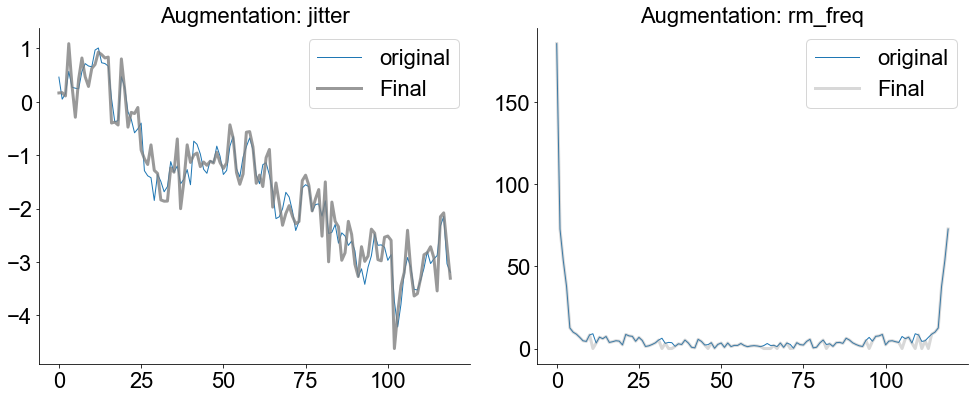

In [46]:
# inspect data augmented points

n = 13
ch = 0

TDaugNames = ['jitter', 'scale', 'permute']
FDaugNames = ['rm_freq', 'add_freq']

fig, (ax, ax1) = plt.subplots(1, 2, figsize=(14,6))

ax.plot(x_t[n, ch,:].detach().numpy(), lw=1, label='original')
ax.plot(x_t_aug[n, ch,:].detach().numpy(), lw=3, alpha=0.8, color='grey', label='Final')
ax.set_title(f'Augmentation: {TDaugNames[np.argmax(msk_t[n].tolist())]}')
ax.legend()
ax1.plot(x_f[n, ch,:].detach().numpy(), lw=1, label='original')
ax1.plot(x_f_aug[n, ch,:].detach().numpy(), lw=3, alpha=0.3, color='grey', label='Final')
ax1.set_title(f'Augmentation: {FDaugNames[np.argmax(msk_f[n].tolist())]}')
ax1.legend()
# ax1.set_ylim(0, 20)
# ax1.set_xlim(150, 250)

In [13]:
# Build TFC feature detector and classifier

TFC_model = TFCmultiToOne(configs).to(device)
classifier = ClassifierMultiToOne(
    configs,
    num_chans=finetune_dataset['samples'].shape[1]).to(device)

cprint(TFC_model, color='grey')

cprint(classifier, color='red')

number of parameters in model: 65520
number of parameters in model: 12714
TFCmultiToOne(
  (conv_block1_t): Sequential(
    (0): Conv1d(1, 32, kernel_size=(25,), stride=(3,), padding=(12,), bias=False)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.35, inplace=False)
  )
  (conv_block2_t): Sequential(
    (0): Conv1d(32, 64, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_block3_t): Sequential(
    (0): Conv1d(64, 20, kernel_size=(8,), stride=(1,), padding=(4,), bias=False)
    (1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=2, stride=2,

In [14]:
# load model parameters
TFC_model.load_state_dict(torch.load('TFC_model_1chRearrange_BIGGER_pretrained_389ep.wts'))

<All keys matched successfully>

In [50]:
# pretrain:

wandb.config = configs
wandb.init(project="TFC_1ch_BIGGER_rearrange_pretraining", 
           entity="nightdude",
           config=wandb.config,
           save_code=False)
wandb.watch(TFC_model, log_freq=20)

# instantiate the Dataset class
pretrain_ds = MIdatasetMC(pretrain_dataset, configs)

# instantiate a dataloader for the fine-tuning dataset
pretrain_dl = torch.utils.data.DataLoader(
    dataset=pretrain_ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=14) # optimal: 14 workers with batch_size=60

TFC_model.train()
model_optimizer = torch.optim.AdamW(TFC_model.parameters(),  # <<<<<<<<<<<<<<<<<< !!!!!!
                                   lr=configs.lr,
                                   betas=(configs.beta1, configs.beta2),
                                   weight_decay=3e-4)

nt_xent_criterion = NTXentLoss_poly(
            device,
            configs.batch_size,
            configs.Context_Cont.temperature,
            configs.Context_Cont.use_cosine_similarity, 
            batch_mult = pretrain_dataset['samples'].shape[1])  # needed for the reaarrange variant. Leave at default for others.

EPOCHS = 450
L, total_loss = [], []


for ep in range(0, EPOCHS):
    for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in tqdm(enumerate(pretrain_dl)):

        x_t, y = x_t.float().to(device), y.long().to(device)
        x_t_aug = x_t_aug.float().to(device)
        x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)
        
        model_optimizer.zero_grad()

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = TFC_model(x_t, x_f)                         # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(x_t_aug, x_f_aug) # augmented data


        
        loss_t = nt_xent_criterion(h_t, h_t_aug) # original and perturbed data should be close in TD embedding space
        loss_f = nt_xent_criterion(h_f, h_f_aug) # original and perturbed data should be close in FD embedding space

        # time and frequency embeddings should be similar when projected to the joint TF space
        l_TF, l_1, l_2, l_3 = (
            nt_xent_criterion(z_t, z_f),
            nt_xent_criterion(z_t, z_f_aug),
            nt_xent_criterion(z_t_aug, z_f),
            nt_xent_criterion(z_t_aug, z_f_aug))
        
        # Each of the 3 terms below optimize the model towards a smaller l_TF and relatively larger l_(1,2,3)
        loss_c = (1 + l_TF - l_1) + (1 + l_TF - l_2) + (1 + l_TF - l_3) 

        lam = 0.2
        loss = lam * (loss_t + loss_f) + (1 - lam) * loss_c

        total_loss.append(loss.item())

        performance_now = {'ep': ep,
                  'it': i,
                  'temporal contr. loss': loss_t.item(),
                  'frequency contr. loss': loss_f.item(),
                  'TF consistency loss': l_TF.item(),
                  'TFaug consistency loss': l_1.item(),
                  'TaugF consistency loss': l_2.item(),
                  'TaugFaug consistency loss': l_3.item()}
        L.append(performance_now)
#         if i % 10:
        wandb.log(performance_now)
        
        loss.backward()
        model_optimizer.step()
wandb.finish()

wandb: Currently logged in as: nightdude. Use `wandb login --relogin` to force relogin


torch.Size([48295, 7, 120])


503it [02:15,  3.72it/s]
293it [01:18,  3.92it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
330it [01:28,  3.72it/s]wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
341it [01:31,  3.73it/s]
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc210fa4940>
Traceback (most recent call last):
  File "/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    self._shutdown_workers()
  File "/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/torch/utils/data/dataloader.py", line 1474, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/roman/miniconda3/envs/tachikoma/lib/python3.9/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/roman/miniconda3/envs/tachikoma/lib/python3.9/multip

KeyboardInterrupt: 

# project embeddings into 2-D space (UMAP or tSNE)

In [56]:


# load a pre-trained feature extractor and set it to eval mode
TFC_model = TFCmultiToOne(configs).to(device)
TFC_model.load_state_dict(torch.load('TFC_model_1chRearrange_BIGGER_pretrained_389ep.wts'))
TFC_model.eval()

# instantiate the Dataset class
pretrain_ds = MIdatasetMC(pretrain_dataset, configs)

# instantiate a dataloader for the fine-tuning dataset
pretrain_dl = torch.utils.data.DataLoader(
    dataset=pretrain_ds,
    batch_size=configs.batch_size,
    shuffle=True,
    drop_last=True,
    pin_memory=False,
    num_workers=14) # optimal: 14 workers with batch_size=60

HT, ZT, HF, ZF, Y = [], [], [], [], []

# embed each datapoint in the dataset
for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in tqdm(enumerate(pretrain_dl)):
    
    x_t, y = x_t.float().to(device), y.long().to(device)
    x_t_aug = x_t_aug.float().to(device)
    x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)
        
        
    h_t, z_t, h_f, z_f = TFC_model(x_t, x_f)
    
    HT.append(h_t.reshape(configs.batch_size,7,-1).detach().cpu().numpy())
    ZT.append(z_t.reshape(configs.batch_size,7,-1).detach().cpu().numpy())
    HF.append(h_f.reshape(configs.batch_size,7,-1).detach().cpu().numpy())
    ZF.append(z_f.reshape(configs.batch_size,7,-1).detach().cpu().numpy())
    Y += y.tolist()
    
HT = np.stack(HT).reshape(-1,7,140)
HF = np.stack(HF).reshape(-1,7,140)
ZT = np.stack(ZT).reshape(-1,7,16)
ZF = np.stack(ZF).reshape(-1,7,16)

number of parameters in model: 65520
torch.Size([48295, 7, 120])


503it [00:04, 105.88it/s]


In [58]:
# embeddings
HF.shape, ZF.shape, len(Y)

((48288, 7, 140), (48288, 7, 16), 48288)

In [65]:
%%time
chan = 3
# C = umap.UMAP(random_state=42).fit_transform(HT[:,chan,:]).T
C = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3).fit_transform(HT[:,chan,:]).T

CPU times: user 22min 42s, sys: 10min 58s, total: 33min 41s
Wall time: 2min 1s


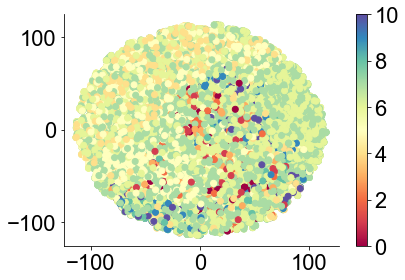

In [67]:
plt.scatter(C[0,:], C[1,:], c=Y, cmap='Spectral')
plt.colorbar()

In [30]:
# save model parameters
# torch.save(TFC_model.state_dict(), 'TFC_model_1chRearrange_BIGGER_pretrained_389ep.wts')

Text(0.5, 0, 'batches')

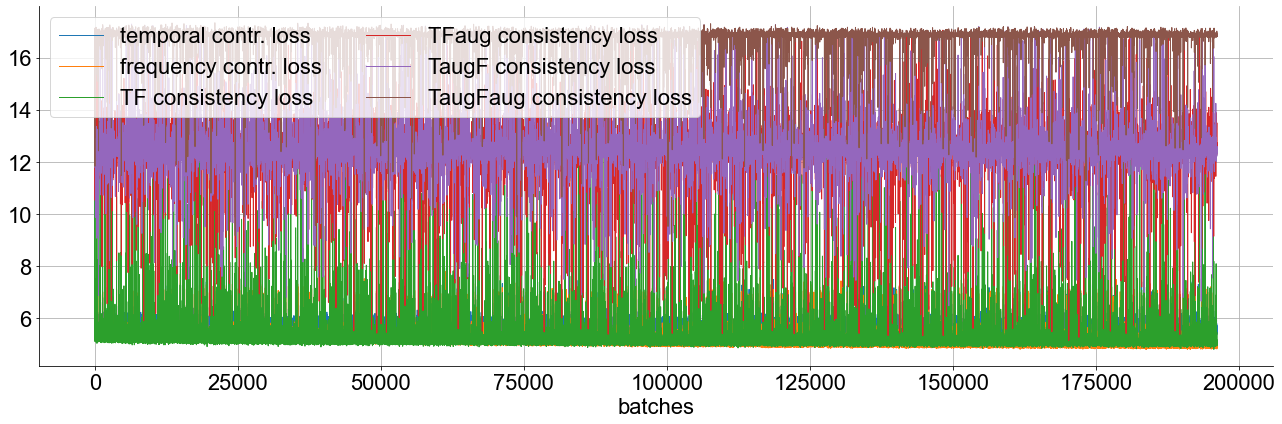

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(18, 6))
pd.DataFrame(L).plot(y=['temporal contr. loss',
                        'frequency contr. loss',
                        'TF consistency loss',
                        'TFaug consistency loss',
                        'TaugF consistency loss',
                        'TaugFaug consistency loss'],
                     ax=ax, lw=1,
                     legend=None)
ax.legend(ncol=2, loc='upper left')
ax.grid()
ax.set_xlabel('batches')

In [ ]:
# ******************

# now fine-tune

In [21]:
len(finetune_dataset['samples'])

4873

In [31]:

# build models from scratch
TFC_model = TFCmultiToOne(configs).to(device)

# the classifier must know how many EEG channels there are in the data
# classifier = ClassifierMultiToOne(configs,
#                                   num_chans=finetune_dataset['samples'].shape[1]).to(device)

classifier = ClassifierMultiToOneEEGNetLike(
    num_chan=7, kerLen=1, drop=0.5, F1=8, D=2, F2=16, nclass=2, device=device)

# with a spatial filter over channel-specific features
# classifier = ClassifierMultiToOne_spatial(configs,
#                                           num_chans=finetune_ds[0][0].shape[0]).to(device)

# load pre-trained weights into the contrastive feature detector model, but not the classifier
TFC_model.load_state_dict(torch.load('TFC_model_1chRearrange_BIGGER_pretrained_389ep.wts'))

number of parameters in model: 65520


/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [32]:
# HACK!
classifier.summary(num_time_samples=TFC_model.h_dim)

******************************************************************************************
For 140 time samples, the network will look like this:
------------------------------------------------------------------------------------------
Conv2d(1, 8, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
------------------------------------------------------------------------------------------
Input: torch.Size([10, 1, 7, 140])
weight, torch.Size([8, 1, 1, 1]), Nparams: 8
Output: torch.Size([10, 8, 7, 140])

------------------------------------------------------------------------------------------
BatchNorm2d(8, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
------------------------------------------------------------------------------------------
Input: torch.Size([10, 8, 7, 140])
weight, torch.Size([8]), Nparams: 8
bias, torch.Size([8]), Nparams: 8
Output: torch.Size([10, 8, 7, 140])

------------------------------------------------------------------------------

In [33]:
%%time
# finetune

epochs = 200
freeze = True

df = finetune(TFC_model, classifier, finetune_dataset, test_dataset, configs, device, epochs, freeze)

USING ONLY H_T FOR CLASSIFICATION


AUC,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▄▅▆▅▅▆▆▆▆▆▆▆▇▇▇▇█▇██▇█▇█▇
F1-score,▁▁▂▃▃▄▄▄▄▄▅▅▅▆▅▅▆▇▆▆▆▆▆▆▇▇▆▇▇▇▇▇▇██▇██▇█
PRC,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▄▄▆▅▅▆▆▆▆▆▆▇▇▇▇▇█▇█▇▇█▇█▇
aug.time - aug. freq (~t-~f) consistency,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
aug.time - freq (~t-f) consistency,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
classifier accuracy,▁▁▂▂▃▄▄▄▃▄▅▅▅▅▅▅▆▆▆▆▆▅▆▆▆▇▆▇▇▇▇▇▇█▇▇██▇█
classifier loss,█▇▆▆▅▅▄▄▄▄▄▄▄▃▃▄▄▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▂▁▁▂▁▂▁▂
ep,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
frequency contrastive loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
kappa,▁▁▂▂▃▃▄▄▃▄▅▅▅▆▅▅▆▆▆▆▆▅▆▆▇▇▆▇▇▇▇▇▇██▇██▇█
precision,▁▁▂▂▃▃▄▄▃▄▅▅▅▆▅▅▆▆▆▆▆▅▆▆▇▇▆▇▇▇▇▇▇██▇██▇█


torch.Size([4873, 7, 120])

Class 0 weight: 1.01

Class 1 weight: 0.99
Feature detector's parameters are frozen


L0: 0.72 w0: 0.96 L1: -15.98 w1: 0.04: : 50it [00:03, 12.85it/s]
L0: 0.73 w0: 0.96 L1: -16.53 w1: 0.04: : 50it [00:03, 12.68it/s]
50it [00:01, 48.61it/s]
50it [00:00, 51.01it/s]
50it [00:01, 48.72it/s]
50it [00:01, 48.59it/s]
50it [00:00, 50.14it/s]
50it [00:01, 49.87it/s]
50it [00:01, 48.99it/s]
50it [00:01, 48.97it/s]
50it [00:01, 48.34it/s]
50it [00:01, 45.27it/s]
50it [00:01, 48.74it/s]
50it [00:01, 46.61it/s]
50it [00:01, 48.77it/s]
50it [00:01, 49.38it/s]
50it [00:01, 48.96it/s]
50it [00:01, 43.95it/s]
50it [00:01, 46.54it/s]
50it [00:01, 46.06it/s]
50it [00:01, 49.90it/s]
50it [00:01, 48.50it/s]
50it [00:01, 47.01it/s]
50it [00:01, 46.98it/s]
50it [00:01, 47.77it/s]
50it [00:01, 45.55it/s]
50it [00:00, 50.72it/s]
50it [00:01, 48.25it/s]
50it [00:01, 46.67it/s]
50it [00:01, 48.04it/s]
50it [00:00, 53.03it/s]
50it [00:01, 47.56it/s]
50it [00:01, 48.67it/s]
50it [00:00, 50.90it/s]
50it [00:01, 47.65it/s]
50it [00:01, 35.69it/s]
50it [00:01, 35.30it/s]
50it [00:01, 38.85it/s]
50it [

Feature detector's parameters are unfrozen
CPU times: user 23min 57s, sys: 4min 19s, total: 28min 17s
Wall time: 8min 32s


In [47]:

# instantiate the Dataset class
finetune_ds = MIdatasetMC(finetune_dataset, configs)

# instantiate a dataloader for the fine-tuning dataset
finetune_dl = torch.utils.data.DataLoader(dataset=finetune_ds,
                                          batch_size=configs.batch_size,
                                          shuffle=True,
                                          drop_last=True,
                                          num_workers=14)  # optimal: 14 workers with batch_size=60

y = finetune_dataset['labels'].tolist()

model_optimizer = torch.optim.Adam(TFC_model.parameters(),
                                   lr=configs.lr,
                                   betas=(configs.beta1, configs.beta2),
                                   weight_decay=3e-4)

classifier_optimizer = torch.optim.Adam(classifier.parameters(),
                                        lr=configs.lr,
                                        betas=(configs.beta1, configs.beta2),
                                        weight_decay=3e-4)

# See explanation in TFC_7ch_Sandbox.ipynb
nt_xent_criterion = NTXentLoss_poly(
    device,
    configs.batch_size,
    configs.Context_Cont.temperature,
    configs.Context_Cont.use_cosine_similarity,
    batch_mult=finetune_dataset['samples'].shape[1]
)  # needed for the reaarrange variant. Leave at default for others.)  # device, 128, 0.2, True

# reduction?
criterion = torch.nn.CrossEntropyLoss(reduction='mean')

dat = []

if freeze:
    for i, param in enumerate(TFC_model.parameters()):
        param.requires_grad = False
    cprint("Feature detector's parameters are frozen", color='blue')
else:
    cprint("Feature detector's parameters are NOT frozen", color='blue')

for ep in range(1):

    TFC_model.train()
    classifier.train()

    TCL = []
    FCL = []
    TFC = []
    TFaC = []
    TaFC = []
    TaFaC = []
    CL = []
    TotL = []
    Cacc = []
    AUC = []
    PRC = []
    REC = []
    PREC = []
    F1 = []

    pbar = tqdm(enumerate(finetune_dl))
    for i, (x_t, y, x_t_aug, x_f, x_f_aug, msk_t, msk_f, meta) in pbar:

        x_t, y = x_t.float().to(device), y.long().to(device)
        x_t_aug = x_t_aug.float().to(device)
        x_f, x_f_aug = x_f.float().to(device), x_f_aug.float().to(device)

        classifier_optimizer.zero_grad()

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = TFC_model(x_t, x_f)  # original data

        if (not freeze) or (ep < 2):
            model_optimizer.zero_grad()
            h_t_aug, z_t_aug, h_f_aug, z_f_aug = TFC_model(x_t_aug, x_f_aug)  # augmented data

            # contrastive time loss (encourages learning representations that are invariant to noise, translations and amplification)
            # contrastive frequency loss (encourages learning representations that are invariant to spectrum perturbations)
            loss_t = nt_xent_criterion(h_t,
                                       h_t_aug)  # original and perturbed data should be close in TD embedding space
            loss_f = nt_xent_criterion(h_f,
                                       h_f_aug)  # original and perturbed data should be close in FD embedding space

            # time and frequency embeddings should be similar when projected to the joint TF space
            l_TF, l_1, l_2, l_3 = (nt_xent_criterion(z_t, z_f), nt_xent_criterion(z_t, z_f_aug),
                                   nt_xent_criterion(z_t_aug, z_f), nt_xent_criterion(z_t_aug, z_f_aug))

            # Each of the 3 terms below optimize the model towards a smaller l_TF and relatively larger l_(1,2,3)
            # similar to triplet loss, l_TF should be smaller than l_{1,2,3}.
            # time-frequency consistency loss. same samples should be close in TF space, but augmented samples should not be so close to augmented/not augmented
            loss_c = (1 + l_TF - l_1) + (1 + l_TF - l_2) + (1 + l_TF - l_3)

        # classifier
        fea_concat = torch.cat((z_t, z_f), dim=1)

        predictions = classifier(fea_concat)  # how to define classifier? MLP? CNN?
        # fea_concat_flat = fea_concat.reshape(fea_concat.shape[0], -1)
        loss_class = criterion(predictions, y)  # predictor loss, actually, here is training loss

        if (not freeze) or (ep < 2):
            lam = 0.2
            feature_loss = (1 - lam) * loss_c + lam * (loss_t + loss_f)

            loss = loss_class + feature_loss
        else:
            loss = loss_class

        acc_bs = y.eq(predictions.detach().argmax(dim=1)).float().mean()
        onehot_label = F.one_hot(y, num_classes=2)
        pred_numpy = predictions.argmax(axis=1).detach().cpu().numpy()
        labels_numpy = y.detach().cpu().numpy()


        break
        
        

torch.Size([3934, 7, 120])
Feature detector's parameters are frozen


0it [00:00, ?it/s]


In [48]:
labels_numpy.shape, pred_numpy.shape

((96,), (96,))

In [24]:
labels_numpy

array([1])

In [23]:
# dat = pd.DataFrame(dat)
df.columns

Index(['ep', 'temporal contrastive loss', 'frequency contrastive loss',
       'time-frequency (t-f) consistency',
       'time - aug. freq (t-~f) consistency',
       'aug.time - freq (~t-f) consistency',
       'aug.time - aug. freq (~t-~f) consistency', 'classifier loss',
       'total_loss', 'classifier accuracy', 'AUC', 'PRC', 'recall',
       'precision', 'F1-score', 'test_acc'],
      dtype='object')

<AxesSubplot:>

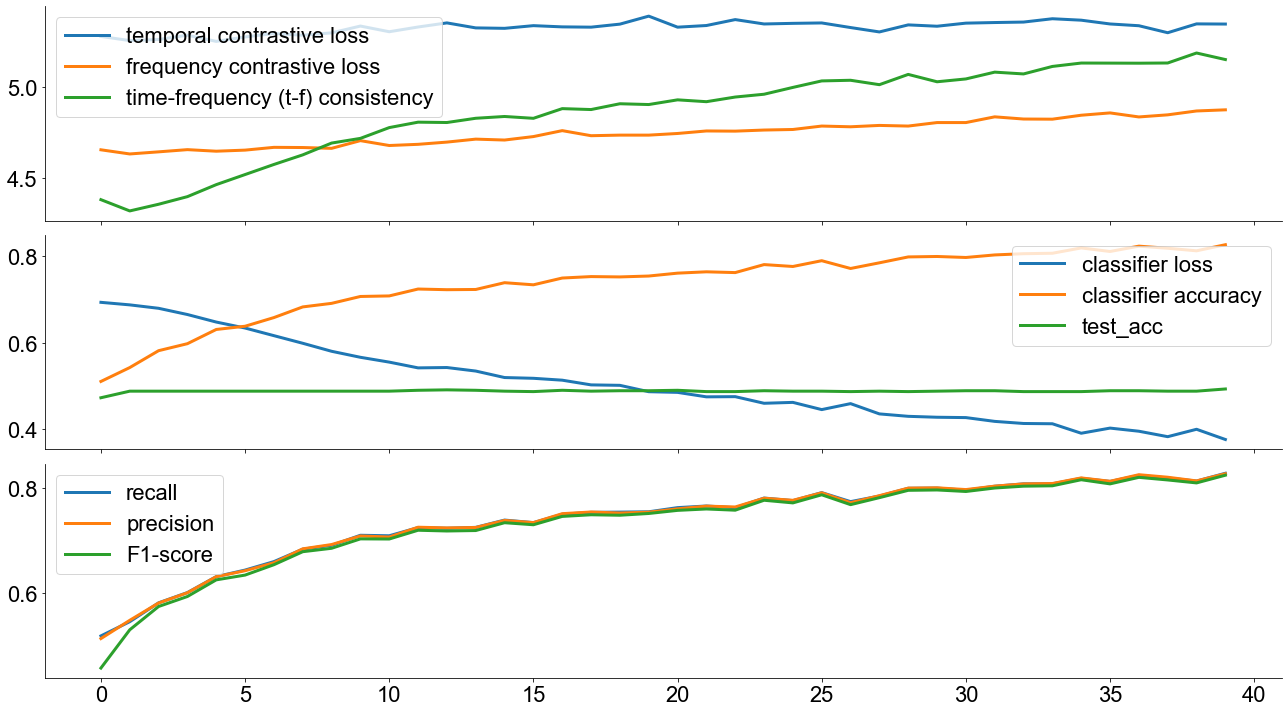

In [24]:
fig, ax = plt.subplots(3, 1, figsize=(18, 10), sharex=True)
df.plot(y=['temporal contrastive loss',
            'frequency contrastive loss',
            'time-frequency (t-f) consistency'], ax=ax[0])

df.plot(y=['classifier loss', 'classifier accuracy', 'test_acc'], ax=ax[1])

df.plot(y=['recall', 'precision', 'F1-score'], ax=ax[2])

In [12]:
# Cz weight should be smallest

for w, ch in zip(classifier.spatial_filter.weight[0].tolist(), ['F3', 'F4', 'Fz', 'Cz', 'P3', 'P4', 'Pz']):
    print(ch, w)

AttributeError: 'ClassifierMultiToOne' object has no attribute 'spatial_filter'

In [123]:
def test_model(model, classifier, test_dl):
    model.eval()
    classifier.eval()

    total_loss = []
    total_acc = []
    total_auc = []
    total_prc = []   

    for data, labels, aug1, data_f, aug1_f in tqdm(test_dl):
        data, labels = data.float().to(device), labels.long().to(device)
        data_f = data_f.float().to(device)
        aug1 = aug1.float().to(device)
        aug1_f = aug1_f.float().to(device)
            

        # embed time representation and frequency representations (h). Z's are projections into joint TF space
        h_t, z_t, h_f, z_f = model(data, data_f)                 # original data
        h_t_aug, z_t_aug, h_f_aug, z_f_aug = model(aug1, aug1_f) # augmented data


        fea_concat = torch.cat((z_t, z_f), dim=1)
        predictions = classifier(fea_concat)  # how to define classifier? MLP? CNN?
        
        
        acc_bs = labels.eq(predictions.detach().argmax(dim=1)).float().mean()
        onehot_label = F.one_hot(labels) # <<<<<<<<<<<<<<<<<<<<<<<<<<<<< num_ classes !!!!
        pred_numpy = predictions.detach().cpu().numpy()

        auc_bs = roc_auc_score(
            onehot_label.detach().cpu().numpy(),
            pred_numpy,
            average="macro",
            multi_class="ovr")
        prc_bs = average_precision_score(
            onehot_label.detach().cpu().numpy(),
            pred_numpy)

        total_acc.append(acc_bs.item())
        total_auc.append(auc_bs.item())
        total_prc.append(prc_bs.item())
        
        
    labels_numpy = labels.detach().cpu().numpy()
    pred_numpy = np.argmax(pred_numpy, axis=1)
    precision = precision_score(labels_numpy, pred_numpy, average="macro")
    recall = recall_score(labels_numpy, pred_numpy, average="macro")
    F1 = f1_score(labels_numpy, pred_numpy, average="macro")
    return (total_acc, total_auc, total_prc, 
            precision, recall, F1, LOSS_P, 
            labels_numpy, pred_numpy)

In [124]:
(total_acc, total_auc, total_prc, 
            precision, recall, F1, LOSS_P, 
            labels_numpy, pred_numpy) = test_model(TFC_model, classifier, test_dl)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:01<00:00, 127.62it/s]
/home/roman/miniconda3/envs/tachikoma/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


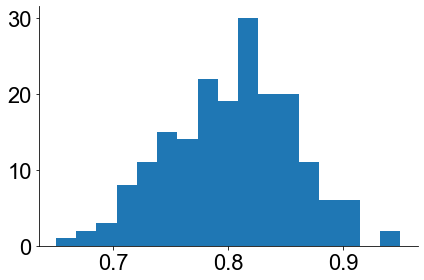

In [125]:
_ = plt.hist(total_acc, bins=17)